# Linear Regression Vectorized

Vectorized Implementation of Linear Regression

In [93]:
from collections import namedtuple

Model = namedtuple('Model', ['W', 'b'])
State = namedtuple('State', ['loss', 'dW', 'db'])

In [95]:
class LinearRegression:
    def __init__(self, X, ys, W=None, b=0.0, learning_rate=0.001, batch_size=None):
        # Initialize starting weights and biases
        (self.M,) = X.shape
        
        self.X, self.ys_train = X.reshape(1,M), ys
        self.learning_rate = learning_rate
        
        self.W = np.array([0.0]) if not W else W
        self.b = 0.0
        
        self.batch_size = self.M if not batch_size else batch_size
        self.batch_index = 0
        
    def forward_backward_prop(self, W=None, b=None):
        """Perform forward and backward prop over a minibatch of training examples
        
        Returns loss and gradients
        
        """
        W = self.W if not W else W
        b = self.b if not b else b
        
        # Get minibatch of training examples
        low, high = self.batch_index*self.batch_size, (self.batch_index+1)*self.batch_size
        X = self.X[0, low:high].reshape(1, self.batch_size)
        
        # Forward Pass (predictions)
        y_hats = W @ X + b

        # Loss
        losses = 0.5 * (y_hats-self.ys_train[low:high])**2
        loss = sum(losses)

        # Backpropagate to find dw and db
        dlosses = np.ones_like(losses)
        dy_hats = (y_hats-self.ys_train[low:high]) * dlosses
        db = sum(dy_hats)
        dW = dy_hats @ X.T
        
        return State(loss/self.M, dW/self.M, db/self.M)
    
    def step(self):
        """Run one iteration of batch gradient descent"""
        
        loss, dW, db = self.forward_backward_prop()
        
        self.W -= self.learning_rate*dW
        self.b -= self.learning_rate*db
        
        # Update batch index so the next time the next batch in line is used
        self.batch_index = (self.batch_index+1) % (self.M//self.batch_size)
        
        return Model(self.W, self.b)

## Create Synthetic Data

/home/ebanner/.anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


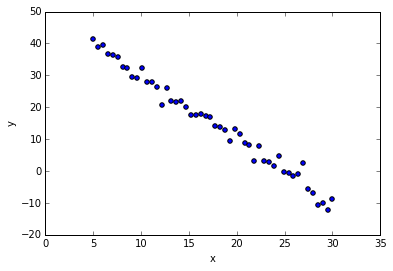

In [77]:
M = 50

X_train = np.linspace(5, 30, num=M)
w_true, b = np.array([-2.0]), 50

# Compute ys
noise_level = 2
ys_train = w_true[0]*X_train + b
ys_train = np.array([y + np.random.randn()*noise_level for y in ys_train])

pd.DataFrame({'x': X_train, 'y': ys_train}).plot(kind='scatter', x='x', y='y')

## How Does the Model Evolve Over Time?

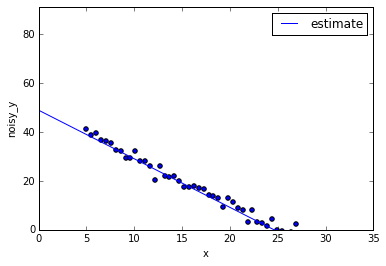

In [88]:
from ipywidgets import interact, fixed

lr = LinearRegression(X_train, ys_train)
def estimates(iters):
    for _ in range(iters):
        yield lr.step()
    
estimates = list(estimates(150000))

@interact(X=fixed(X_train), ys=fixed(ys_train), view_index=(0, len(estimates)), estimates=fixed(estimates))
def plot(X, ys, view_index, estimates):
    w, b = estimates[view_index]
    
    xs = np.linspace(0, 50)
    
    # Get data into suitable form for plotting
    df1 = pd.DataFrame({'x': X, 'noisy_y': ys})
    df2 = pd.DataFrame({'x': xs, 'estimate': w*xs + b})
    
    # Plot
    axes = df1.plot(kind='scatter', x='x', y='noisy_y')
    axes = df2.plot(ax=axes, x='x', y='estimate')
    
    axes.set_ylim(0, max(ys)+50)
    axes.set_xlim(0, max(X)+5)

## Finite Difference Gradient Check

In [90]:
def numerical_gradients(f, W, b):
    """Compute numerical gradients of f with respect to w and b
    
    Returns approximation for df/dw and df/db
    
    """
    dW, h = np.zeros_like(W), np.zeros_like(W)
    step = 0.00001

    # df/dW
    it = np.nditer(W, flags=['multi_index'])
    while not it.finished:
        ix = it.multi_index
        h[ix] = step
        
        dW[ix] = (f(W+h, b)-f(W-h, b)) / (2*step)
        
        h[ix] = 0
        it.iternext()
        
    # df/db
    db = (f(W, b+step)-f(W, b-step)) / (2*step)

    return dW, db

## Run Through a Few Iterations and Assert Analytic and Numerical Gradients are Close

In [101]:
lr = LinearRegression(X_train, ys_train)

for _ in range(10):
    # Analytic gradient computed via backprop
    _, analytic_dW, analytic_db = lr.forward_backward_prop()
    
    # Numerical gradient computed via twiddling w and b and inspecting loss
    numerical_dW, numerical_db = numerical_gradients(lambda W, b: lr.forward_backward_prop(W, b).loss, lr.W, lr.b)
    
    # Compute relative error
    dW_error = abs(numerical_dW - analytic_dW) / (abs(numerical_dW) + abs(analytic_dW))
    db_error = abs(numerical_db - analytic_db) / (abs(numerical_db) + abs(analytic_db))
    
    try:
        assert(np.linalg.norm(dW_error) < 1e-6 and db_error < 1e-6)
    except AssertionError:
        warn(dw_error)
        warn(db_error)
        
else:
    print('Gradient check passed!')

Gradient check passed!
